计算空间物理学作业7
---
朱英杰

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib import ticker
from matplotlib import rcParams
from matplotlib import patches
import xarray as xr
import scipy.io
import astropy.constants as const
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True
rcParams['font.family'] = 'serif'

/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


先考虑迎风格式下对流方程的解，为了体现出数值的影响，这里我直接取$a=0.7$，整个方程化为 

$\displaystyle \frac{\partial u}{\partial t} + 0.7\frac{\partial u}{\partial x} = 0$

初始条件取了一个阶跃信号，在$i=1000$处从1变为0，因为后面要计算总变差，但由于是非周期性条件，正弦波的总变差总会随着传播减小

解析解是平凡的，由于$\mathrm{d}u/\mathrm{d}t = 0$，只要沿着特征线方向平移初始条件就行了

$\displaystyle u(x,t) = \begin{cases} 
&1, & x\leq 0.7t + 999 \\
&0, &x>0.7t + 999
\end{cases}$

迎风格式
---

In [2]:
data = np.zeros((5000,5000))
x = np.linspace(0,4999,5000)
data[:1000,0] = np.ones(1000)

def update_upwind(data_0,r = 1):
    for i in range(1,5000):
        data_0[0,i] = data_0[0,i-1]
        data_0[1:-1,i] = data_0[1:-1,i-1]-r*(data_0[1:-1,i-1]-data_0[:-2,i-1])
        data_0[4999,i] = data_0[4998,i]
    return data_0


$r = 1$情况下（如果用$r>1$会报错）

In [3]:
data_uw = update_upwind(data)

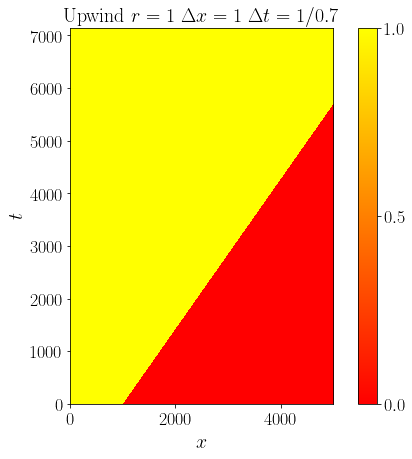

In [4]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.imshow(data_uw.T,origin='lower',cmap='autumn',extent = (0,5000,0,5000/0.7),interpolation='none')
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$t$',fontsize=20)
ax.tick_params(labelsize=18)
ax.set_title(r'Upwind  $r=1$ $\Delta x = 1$ $\Delta t = 1/0.7$',fontsize=20)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ticks=[-1,-0.5,0,0.5,1])
clb.ax.tick_params(labelsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

画一下和解析解的差分，发现全部等于0。其实很好理解因为$r=1$所以导致所有的节点都在特征线上所以不存在高阶项。

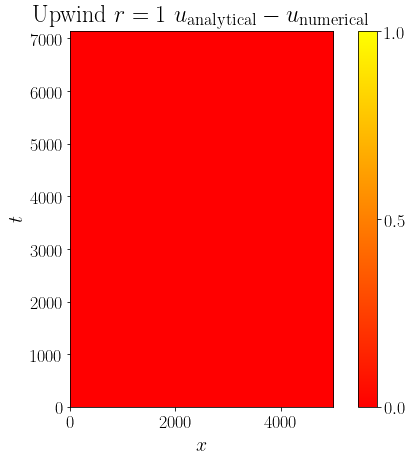

In [5]:
data_ana = np.ones((5000,5000))
for i in range(0,4000):
    data_ana[i+1000:,i] = np.zeros(4000-i) 

data_dev = np.abs(data_ana-data_uw)
fig,ax = plt.subplots(figsize=(8,6))
im = ax.imshow(data_dev.T,origin='lower',cmap='autumn',extent = (0,5000,0,5000/0.7),interpolation='none')
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$t$',fontsize=20)
ax.tick_params(labelsize=18)
ax.set_title(r'Upwind  $r=1$ $u_{\mathrm{analytical}}-u_{\mathrm{numerical}}$',fontsize=24)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ticks=[-1,-0.5,0,0.5,1])
clb.ax.tick_params(labelsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

算一下TV,因为4000步后阶跃信号越过边界所以变为0，其余时间保持不变

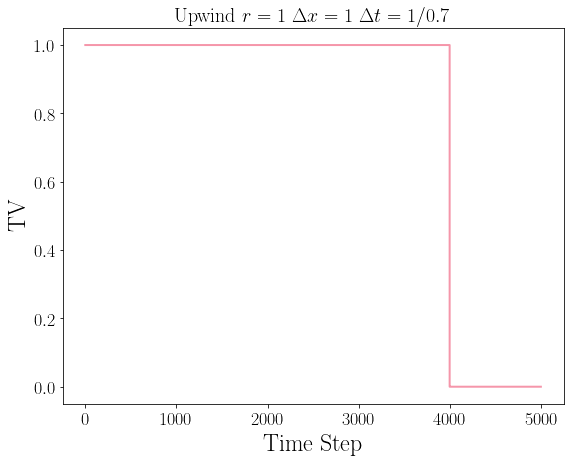

In [6]:
TV_all = np.zeros(5000)
for i in range(5000):
    TV_all[i] = np.abs(data_uw[1:,i]-data_uw[:-1,i]).sum()
fig, ax = plt.subplots(figsize=(8,6))
ln, = ax.step(np.linspace(0,4999,5000),TV_all,color = '#F596AA',linewidth=2,label = '')
ax.set_xlabel(r'Time Step',fontsize=24)
ax.set_ylabel(r'TV',fontsize=24)
ax.tick_params(labelsize=18)
ax.set_title(r'Upwind  $r=1$ $\Delta x = 1$ $\Delta t = 1/0.7$',fontsize=20)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

下面尝试一下$r=0.7$,这样$\Delta x = \Delta t = 1$

In [3]:
data = np.zeros((5000,5000))
x = np.linspace(0,4999,5000)
data[:1000,0] = np.ones(1000)
data_uw = update_upwind(data,r=0.7)

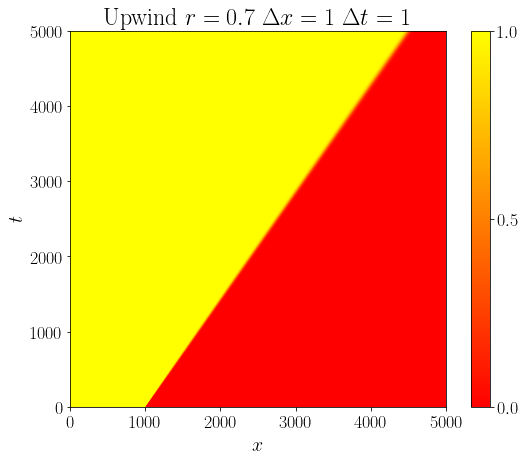

In [4]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.imshow(data_uw.T,origin='lower',cmap='autumn',interpolation='none')
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$t$',fontsize=20)
ax.tick_params(labelsize=18)
ax.set_title(r'Upwind  $r=0.7$ $\Delta x = 1$ $\Delta t = 1$',fontsize=24)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ticks=[-1,-0.5,0,0.5,1])
clb.ax.tick_params(labelsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

其实从上图已经看出来边界有点模糊了（画图没有插值），来算一下和解析解之间的差

In [5]:
data_ana = np.ones((5000,5000))
start  = 1000
for i in range(5000):
    for j in range(start,5000):
        if j>(0.7*i + 999):
            data_ana[j:,i] = np.zeros(5000-j)
            start = j
            break
data_dev = np.abs(data_ana-data_uw)

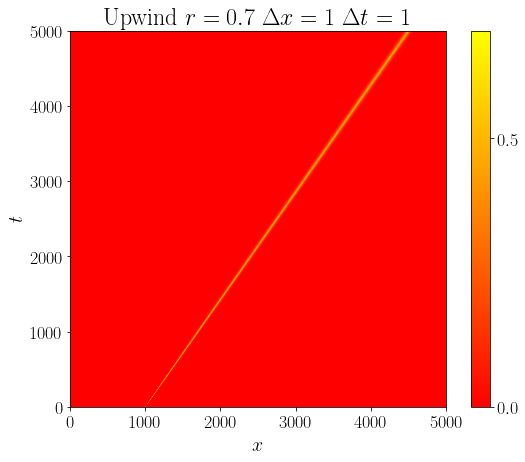

In [6]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.imshow(data_dev.T,origin='lower',cmap='autumn',interpolation='none')
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$t$',fontsize=20)
ax.tick_params(labelsize=18)
ax.set_title(r'Upwind  $r=0.7$ $\Delta x = 1$ $\Delta t = 1$',fontsize=24)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ticks=[-1,-0.5,0,0.5,1])
clb.ax.tick_params(labelsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

可以看到中间明显出现了一条亮线，数值解出现了一些问题。接下来计算一下TV

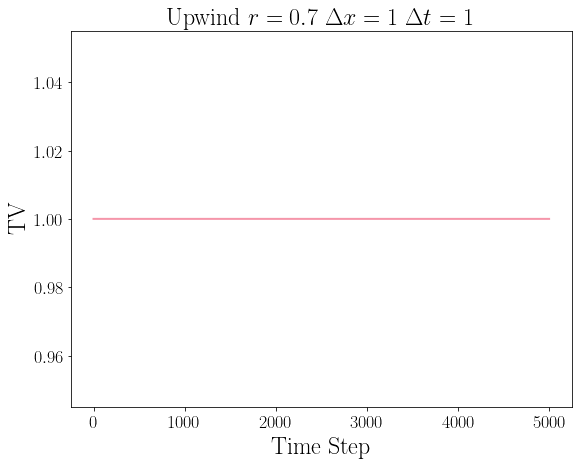

In [7]:
TV_all = np.zeros(5000)
for i in range(5000):
    TV_all[i] = np.abs(data_uw[1:,i]-data_uw[:-1,i]).sum()
fig, ax = plt.subplots(figsize=(8,6))
ln, = ax.step(np.linspace(0,4999,5000),TV_all,color = '#F596AA',linewidth=2,label = '')
ax.set_xlabel(r'Time Step',fontsize=24)
ax.set_ylabel(r'TV',fontsize=24)
ax.tick_params(labelsize=18)
ax.set_title(r'Upwind  $r=0.7$ $\Delta x = 1$ $\Delta t = 1$',fontsize=24)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

TV似乎没有变（因为是阶跃信号。。。），但是如果查看一下结束时刻的波形，阶跃函数很显然已经在数值上出现了变形 

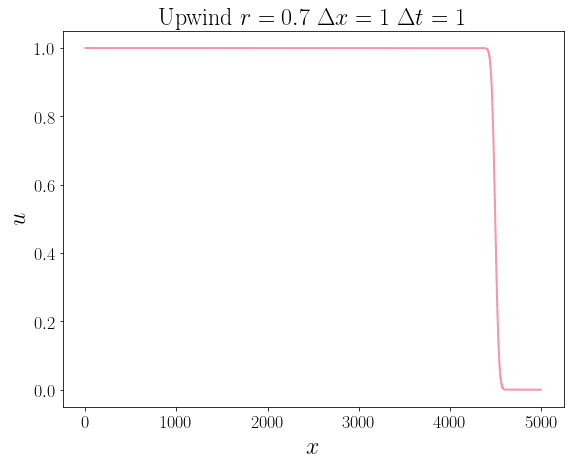

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
ln, = ax.step(x,data_uw[:,4999],color = '#F596AA',linewidth=2,label = '')
ax.set_xlabel(r'$x$',fontsize=24)
ax.set_ylabel(r'$u$',fontsize=24)
ax.tick_params(labelsize=18)
ax.set_title(r'Upwind  $r=0.7$ $\Delta x = 1$ $\Delta t = 1$',fontsize=24)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

蛙跳格式
---
下面来试一下蛙跳格式，依旧先是$r=1$。因为蛙跳格式需要前两步的数据，就先用迎风格式算一步吧

In [2]:
data = np.zeros((5000,5000))
x = np.linspace(0,4999,5000)
data[:1000,0] = np.ones(1000)

def update_frog(data_0,r = 1):
    for i in range(1,5000):
        data_0[0,i] = data_0[0,i-1]
        if i == 1:
            data_0[1:-1,i] = data_0[1:-1,i-1]-r*(data_0[1:-1,i-1]-data_0[:-2,i-1])
        else:
            data_0[1:-1,i] = data_0[1:-1,i-2]-r*(data_0[2:,i-1]-data_0[:-2,i-1])
        data_0[4999,i] = data_0[4998,i]
    return data_0

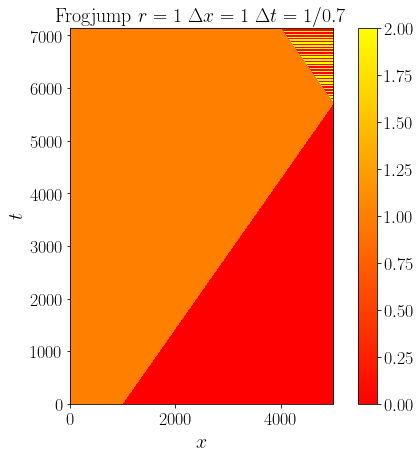

In [3]:
data_frog = update_frog(data)
fig,ax = plt.subplots(figsize=(8,6))
im = ax.imshow(data_frog.T,origin='lower',cmap='autumn',extent = (0,5000,0,5000/0.7),interpolation='none')
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$t$',fontsize=20)
ax.tick_params(labelsize=18)
ax.set_title(r'Frogjump  $r=1$ $\Delta x = 1$ $\Delta t = 1/0.7$',fontsize=20)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical')
clb.ax.tick_params(labelsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

已经可以看到出现了一个很有趣的情况，当阶跃函数通过右边界时会发生类似“反弹”一样的现象，主要来自于

$u^{n+1}_{j} = u^{n-1}_j - r\left(u^{n}_{j+1} - u^{n}_{j-1} \right)$

中在某些情况下会出现$u^{n-1}_j = 1$, $u^{n}_{j+1}=0$, $u^{n}_{j-1} = 1$的情况，应该是要避免的。

下面是和解析解的差分，误差就主要出现在阶跃函数通过右边界处

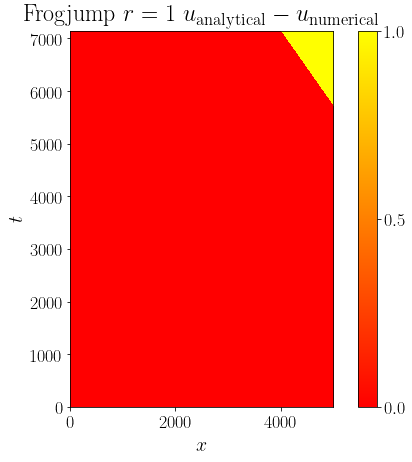

In [4]:
data_ana = np.ones((5000,5000))
for i in range(0,4000):
    data_ana[i+1000:,i] = np.zeros(4000-i) 

data_dev = np.abs(data_ana-data_frog)
fig,ax = plt.subplots(figsize=(8,6))
im = ax.imshow(data_dev.T,origin='lower',cmap='autumn',extent = (0,5000,0,5000/0.7),interpolation='none')
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$t$',fontsize=20)
ax.tick_params(labelsize=18)
ax.set_title(r'Frogjump  $r=1$ $u_{\mathrm{analytical}}-u_{\mathrm{numerical}}$',fontsize=24)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ticks=[-1,-0.5,0,0.5,1])
clb.ax.tick_params(labelsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

TV变化，在阶跃函数通过边界时出现了问题

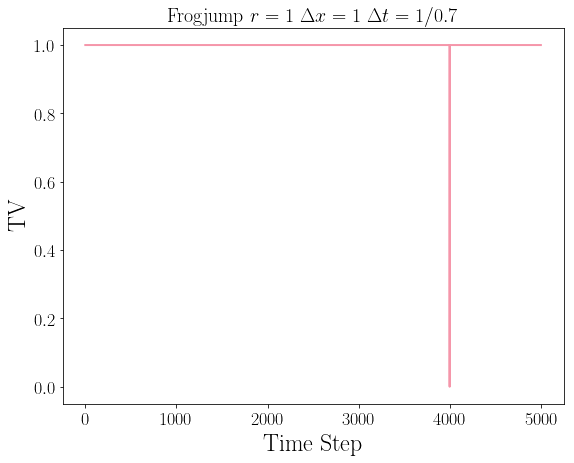

In [5]:
TV_all = np.zeros(5000)
for i in range(5000):
    TV_all[i] = np.abs(data_frog[1:,i]-data_frog[:-1,i]).sum()
fig, ax = plt.subplots(figsize=(8,6))
ln, = ax.step(np.linspace(0,4999,5000),TV_all,color = '#F596AA',linewidth=2,label = '')
ax.set_xlabel(r'Time Step',fontsize=24)
ax.set_ylabel(r'TV',fontsize=24)
ax.tick_params(labelsize=18)
ax.set_title(r'Frogjump  $r=1$ $\Delta x = 1$ $\Delta t = 1/0.7$',fontsize=20)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

下面是蛙跳，$r=0.7$的情况

In [6]:
data = np.zeros((5000,5000))
x = np.linspace(0,4999,5000)
data[:1000,0] = np.ones(1000)
data_frog = update_frog(data,r=0.7)

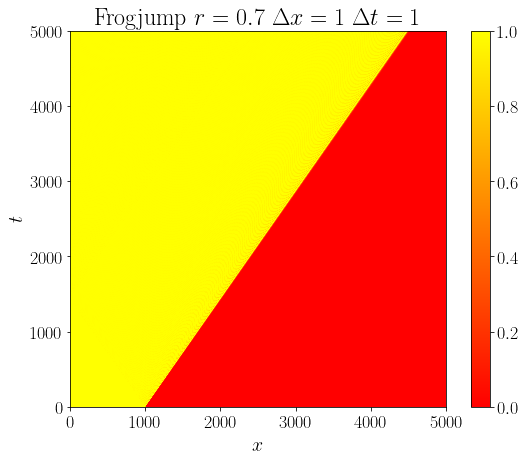

In [7]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.imshow(data_frog.T,origin='lower',cmap='autumn',interpolation='none',vmin=0,vmax=1)
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$t$',fontsize=20)
ax.tick_params(labelsize=18)
ax.set_title(r'Frogjump  $r=0.7$ $\Delta x = 1$ $\Delta t = 1$',fontsize=24)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical')
clb.ax.tick_params(labelsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

看上去还行？来看看和解析解的比较

In [8]:
data_ana = np.ones((5000,5000))
start  = 1000
for i in range(5000):
    for j in range(start,5000):
        if j>(0.7*i + 999):
            data_ana[j:,i] = np.zeros(5000-j)
            start = j
            break
data_dev = np.abs(data_ana-data_frog)

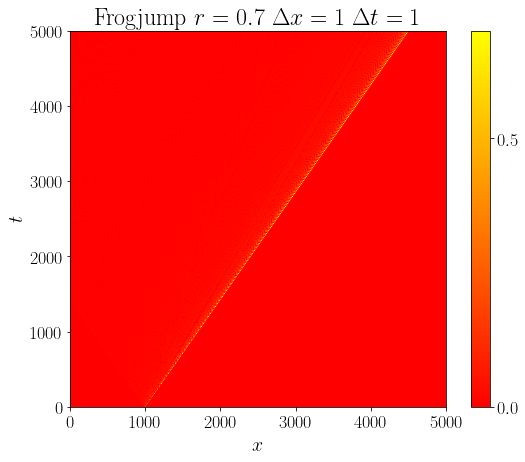

In [9]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.imshow(data_dev.T,origin='lower',cmap='autumn',interpolation='none')
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$t$',fontsize=20)
ax.tick_params(labelsize=18)
ax.set_title(r'Frogjump  $r=0.7$ $\Delta x = 1$ $\Delta t = 1$',fontsize=24)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ticks=[-1,-0.5,0,0.5,1])
clb.ax.tick_params(labelsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

证明在阶跃界面上还是有问题的，TV如下，不断增大

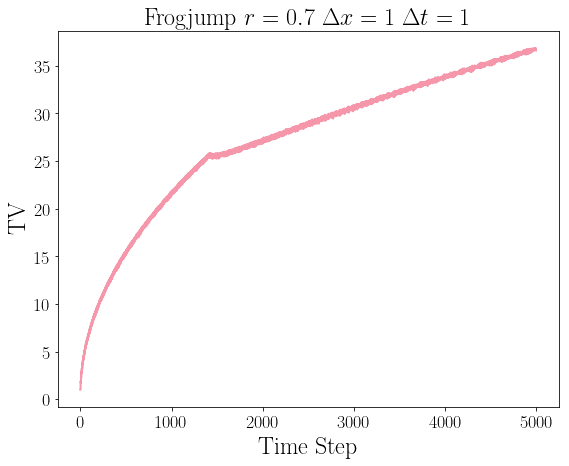

In [10]:
TV_all = np.zeros(5000)
for i in range(5000):
    TV_all[i] = np.abs(data_frog[1:,i]-data_frog[:-1,i]).sum()
fig, ax = plt.subplots(figsize=(8,6))
ln, = ax.step(np.linspace(0,4999,5000),TV_all,color = '#F596AA',linewidth=2,label = '')
ax.set_xlabel(r'Time Step',fontsize=24)
ax.set_ylabel(r'TV',fontsize=24)
ax.tick_params(labelsize=18)
ax.set_title(r'Frogjump  $r=0.7$ $\Delta x = 1$ $\Delta t = 1$',fontsize=24)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

如果我们直接去检查一个中间时刻，可见上游出现了很大的问题

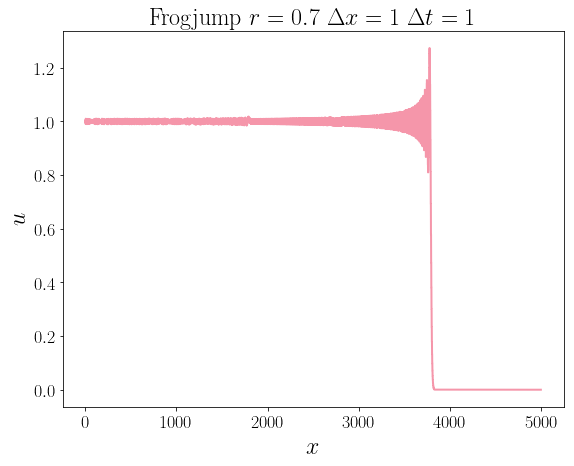

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
ln, = ax.step(x,data_frog[:,3999],color = '#F596AA',linewidth=2,label = '')
ax.set_xlabel(r'$x$',fontsize=24)
ax.set_ylabel(r'$u$',fontsize=24)
ax.tick_params(labelsize=18)
ax.set_title(r'Frogjump  $r=0.7$ $\Delta x = 1$ $\Delta t = 1$',fontsize=24)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

LW格式
---
下面用LW方法，同样从$r=1$开始

In [5]:
data = np.zeros((5000,5000))
x = np.linspace(0,4999,5000)
data[:1000,0] = np.ones(1000)

def update_lw(data_0,r = 1):
    for i in range(1,5000):
        data_0[0,i] = data_0[0,i-1]
        data_0[1:-1,i] = data_0[1:-1,i-1]-0.5*r*(data_0[2:,i-1]-data_0[:-2,i-1])+ 0.5*r*r*(data_0[2:,i-1]-2*data_0[1:-1,i-1]+data_0[:-2,i-1])
        data_0[4999,i] = data_0[4998,i]
    return data_0

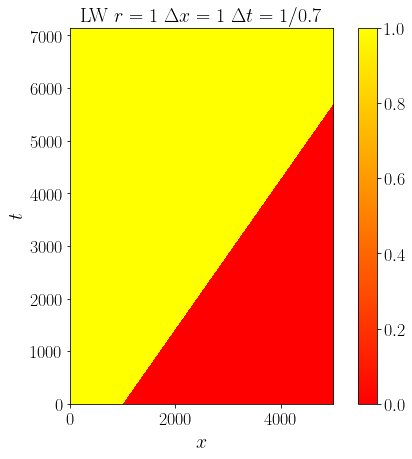

In [6]:
data_lw = update_lw(data)
fig,ax = plt.subplots(figsize=(8,6))
im = ax.imshow(data_lw.T,origin='lower',cmap='autumn',extent = (0,5000,0,5000/0.7),interpolation='none')
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$t$',fontsize=20)
ax.tick_params(labelsize=18)
ax.set_title(r'LW  $r=1$ $\Delta x = 1$ $\Delta t = 1/0.7$',fontsize=20)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical')
clb.ax.tick_params(labelsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

看上去效果不错，看一下与解析解的差，的确得到了准确的结果

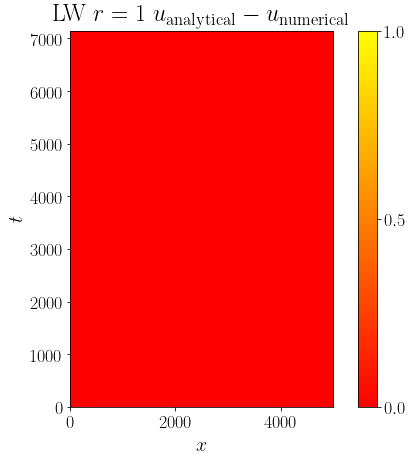

In [7]:
data_ana = np.ones((5000,5000))
for i in range(0,4000):
    data_ana[i+1000:,i] = np.zeros(4000-i) 

data_dev = np.abs(data_ana-data_lw)
fig,ax = plt.subplots(figsize=(8,6))
im = ax.imshow(data_dev.T,origin='lower',cmap='autumn',extent = (0,5000,0,5000/0.7),interpolation='none')
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$t$',fontsize=20)
ax.tick_params(labelsize=18)
ax.set_title(r'LW  $r=1$ $u_{\mathrm{analytical}}-u_{\mathrm{numerical}}$',fontsize=24)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ticks=[-1,-0.5,0,0.5,1])
clb.ax.tick_params(labelsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

算一下TV，没什么问题

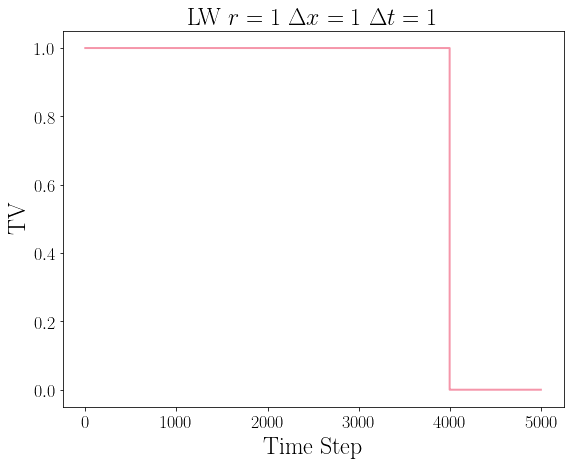

In [8]:
TV_all = np.zeros(5000)
for i in range(5000):
    TV_all[i] = np.abs(data_lw[1:,i]-data_lw[:-1,i]).sum()
fig, ax = plt.subplots(figsize=(8,6))
ln, = ax.step(np.linspace(0,4999,5000),TV_all,color = '#F596AA',linewidth=2,label = '')
ax.set_xlabel(r'Time Step',fontsize=24)
ax.set_ylabel(r'TV',fontsize=24)
ax.tick_params(labelsize=18)
ax.set_title(r'LW  $r=1$ $\Delta x = 1$ $\Delta t = 1$',fontsize=24)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

下面来考虑一下$r=0.7$的情况

In [9]:
data = np.zeros((5000,5000))
x = np.linspace(0,4999,5000)
data[:1000,0] = np.ones(1000)
data_lw = update_lw(data,r=0.7)

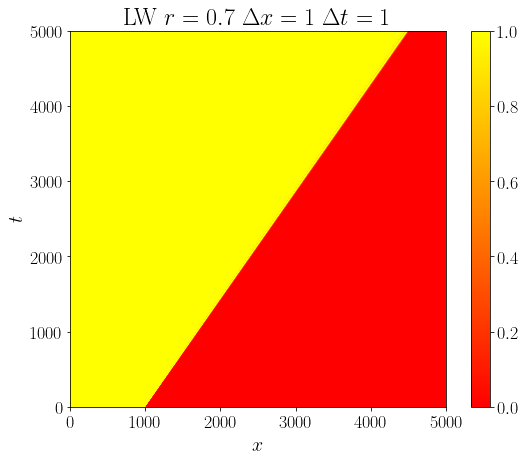

In [10]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.imshow(data_lw.T,origin='lower',cmap='autumn',interpolation='none',vmin=0,vmax=1)
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$t$',fontsize=20)
ax.tick_params(labelsize=18)
ax.set_title(r'LW  $r=0.7$ $\Delta x = 1$ $\Delta t = 1$',fontsize=24)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical')
clb.ax.tick_params(labelsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

结果看上去非常好，和解析解进行比较，实际上在阶跃处还是有点问题

In [14]:
data_ana = np.ones((5000,5000))
start  = 1000
for i in range(5000):
    for j in range(start,5000):
        if j>(0.7*i + 999):
            data_ana[j:,i] = np.zeros(5000-j)
            start = j
            break
data_dev = np.abs(data_ana-data_lw)

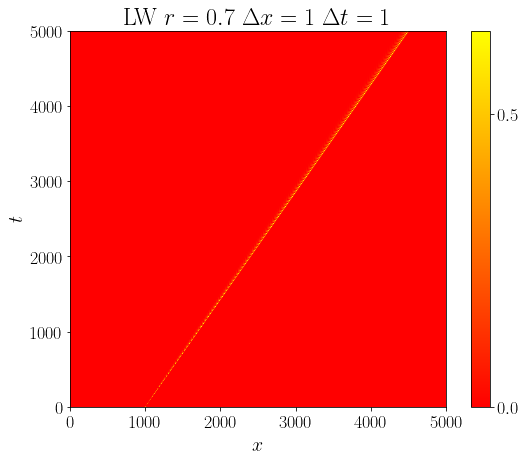

In [15]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.imshow(data_dev.T,origin='lower',cmap='autumn',interpolation='none')
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$t$',fontsize=20)
ax.tick_params(labelsize=18)
ax.set_title(r'LW  $r=0.7$ $\Delta x = 1$ $\Delta t = 1$',fontsize=24)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ticks=[-1,-0.5,0,0.5,1])
clb.ax.tick_params(labelsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

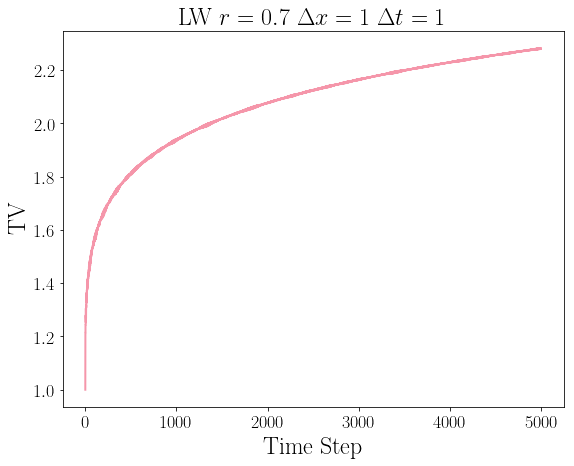

In [19]:
TV_all = np.zeros(5000)
for i in range(5000):
    TV_all[i] = np.abs(data_lw[1:,i]-data_lw[:-1,i]).sum()
fig, ax = plt.subplots(figsize=(8,6))
ln, = ax.step(np.linspace(0,4999,5000),TV_all,color = '#F596AA',linewidth=2,label = '')
ax.set_xlabel(r'Time Step',fontsize=24)
ax.set_ylabel(r'TV',fontsize=24)
ax.tick_params(labelsize=18)
ax.set_title(r'LW  $r=0.7$ $\Delta x = 1$ $\Delta t = 1$',fontsize=24)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

可见TV在增大，如果我们去查看一个具体时刻的话，会发现在阶跃函数附近出现了数值的问题

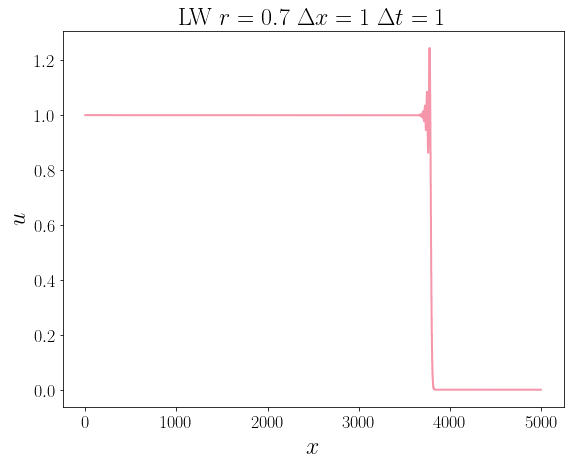

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
ln, = ax.step(x,data_lw[:,3999],color = '#F596AA',linewidth=2,label = '')
ax.set_xlabel(r'$x$',fontsize=24)
ax.set_ylabel(r'$u$',fontsize=24)
ax.tick_params(labelsize=18)
ax.set_title(r'LW  $r=0.7$ $\Delta x = 1$ $\Delta t = 1$',fontsize=24)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

总结
---
我们用下面一个表格总结我们对方程

$\displaystyle \frac{\partial u}{\partial t} + 0.7\frac{\partial u}{\partial x} = 0$

在阶跃函数初始条件和等值边界条件下，通过不同数值格式和$r$取值得到的数值解做一个总结

|格式名称|解的表现|与解析解的差异|TV变化|
|------|------|------|------|
|UW $r=1$|好|完全一致|直到通过右边界前都不变|
|UW $r=0.7$|一般|阶跃出出现数值扩散|直到通过右边界前都不变|
|FJ $r=1$|一般|阶跃未通过右边界前完全一致，遇到右边界会出问题|阶跃通过边界时会出现问题|
|FJ $r=0.7$|不好|阶跃、上游出现数值扩散|增大|
|LW $r=1$|好|完全一致|直到通过右边界前都不变|
|LW $r=0.7$|偏差|阶跃、上游出现数值扩散|增大|